In [1]:
import os
import glob
import numpy as np
import cv2
import torch
import torchvision
import scipy.io as sio
import matplotlib.pyplot as plt
import argparse

import gan_helpers.dataloader as dl
import gan_helpers.gan as gan

In [2]:
def load_dataset(data_dir):
    ct = torchvision.transforms.Compose([dl.ToTensor()])

    dataset_list = []
    dataset_list_test = []

    i = 0
    while True:
        img_dir = os.path.join(data_dir, f"{i:03d}")
        if not os.path.exists(img_dir):
            break
        else:
            i += 1
        
        if i % 5 != 4:
            dataset_list.append(dl.GetSampleBatch(img_dir, ct, bsize=16))
        else:
            dataset_list_test.append(dl.GetSampleBatch(img_dir, ct, bsize=16))

    return dataset_list, dataset_list_test

In [3]:
left_data = os.path.join("bora_data", "left_data")
dataset_list, dataset_list_test = load_dataset(left_data)
train_dataset = torch.utils.data.ConcatDataset(dataset_list)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [52]:
for _ in range(2):
    sample = next(iter(train_loader))

In [53]:
sample_noisy = sample["noisy_imgs"]
sample_clean = sample["clean_imgs"]
sample_exp = sample["exp"]

print(sample_noisy.shape)
print(sample_clean.shape)
print(sample_exp.shape)

torch.Size([1, 16, 1, 480, 640])
torch.Size([1, 16, 1, 480, 640])
torch.Size([1])


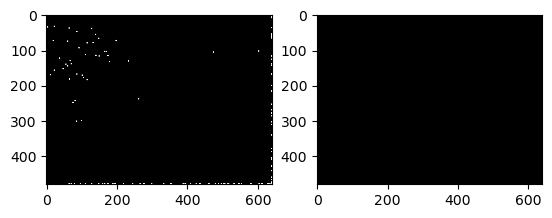

In [64]:
# Show the noisy and clean images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_noisy.numpy()[0, 0, 0], cmap="gray", vmin=0, vmax=2**12-1)
ax[1].imshow(sample_clean.numpy()[0, 0, 0], cmap="gray",vmin=0, vmax=2**12-1)
plt.show()


In [121]:
def simulate(left_clean, right_clean, params, exp):
    H, W = 480, 640
    num_burst, subframes = 1, 1
    if left_clean is not None:
        left_mask = np.ones((subframes, H, W))
        right_mask = np.zeros((subframes, H, W))
        right_clean = np.zeros_like(left_clean)
    else:
        left_mask = np.zeros((subframes, H, W))
        right_mask = np.ones((subframes, H, W))
        left_clean = np.zeros_like(right_clean)

    left_noisy = left_clean * params["left_g"] + \
            params["left_h"]  * (left_mask.sum(axis=0) / subframes)[None,None] + \
            params["left_dark"]**2 * exp * left_mask.sum(axis=0)[None,None]
    left_noisy = np.clip(left_noisy, 0, params["left_fwc"])
    right_noisy = right_clean * params["right_g"] + \
            params["right_h"]  * (right_mask.sum(axis=0) / subframes)[None,None] + \
            params["right_dark"]**2 * exp * right_mask.sum(axis=0)[None,None]
    right_noisy = np.clip(right_noisy, 0, params["right_fwc"])

    left_shot = np.random.normal(size=(num_burst, 1, H, W)) * params["left_shot"] * np.sqrt(left_clean) * params["left_g"]
    left_shot[left_noisy >= params["left_fwc"]] = 0
    left_noisy += left_shot
    right_shot = np.random.normal(size=(num_burst, 1, H, W)) * params["right_shot"] * np.sqrt(right_clean) * params["right_g"]
    right_shot[right_noisy >= params["right_fwc"]] = 0
    right_noisy += right_shot

    left_read = np.random.normal(size=(num_burst, 1, H, W)) * params["left_read"]
    left_noisy += left_read
    right_read = np.random.normal(size=(num_burst, 1, H, W)) * params["right_read"]
    right_noisy += right_read

    left_row = np.random.normal(size=(num_burst, 1, H, 1)) * params["left_row"]
    left_noisy += left_row
    right_row = np.random.normal(size=(num_burst, 1, H, 1)) * params["right_row"]
    right_noisy += right_row

    left_rowt = np.random.normal(size=(1, 1, H, 1)) * params["left_rowt"]
    left_noisy += left_rowt
    right_rowt = np.random.normal(size=(1, 1, H, 1)) * params["right_rowt"]
    right_noisy += right_rowt

    left_quant = np.random.uniform(size=(num_burst, 1, H, W)) * params["left_quant"]
    left_noisy += left_quant
    right_quant = np.random.uniform(size=(num_burst, 1, H, W)) * params["right_quant"]
    right_noisy += right_quant

    left_dark = np.random.normal(size=(num_burst, 1, H, W)) * params["left_dark"] * np.sqrt(exp * left_mask.sum(axis=0)[None,None])
    left_noisy += left_dark
    right_dark = np.random.normal(size=(num_burst, 1, H, W)) * params["right_dark"] * np.sqrt(exp * right_mask.sum(axis=0)[None,None])
    right_noisy += right_dark

    return np.concatenate((left_noisy, right_noisy), axis=3)

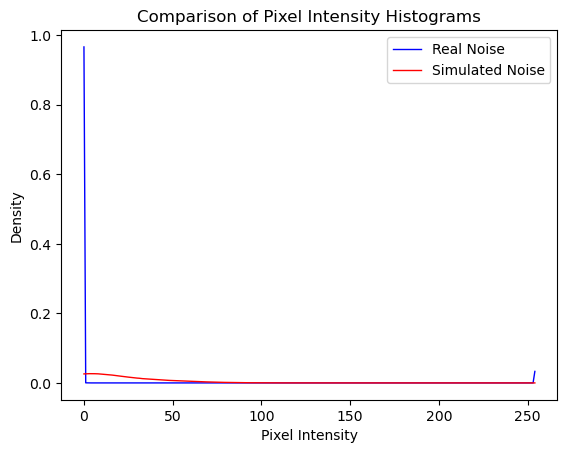

In [142]:
image_folder = '/home/daniel/t7_simulation/bora_data/right_data/032'
params_path = "./bora_data/test_T7_params.mat"
params = sio.loadmat(params_path)
# Initialize an empty list to store all pixel values
all_pixel_values = []
all_pixel_sim_values = []

# Loop through each .npy file (from x0.npy to x255.npy)
exp = os.path.join(image_folder, 'exp.npy')
exp = np.load(exp)[0]
clean_image = os.path.join(image_folder, 'clean.npy')
clean_image = np.load(clean_image)[:, :, 0]
for i in range(12):
    # Construct the file path
    file_path = os.path.join(image_folder, f'noisy{i:04d}.npy')
    
    # Load the image
    image = np.load(file_path)
    image = np.clip(image / 16, 0, 255)
    # Flatten the image and extend the list of pixel values
    all_pixel_values.extend(image.flatten())
    all_pixel_sim_values.extend(simulate(None, clean_image, params, exp).flatten())

# plt.imshow(image, cmap='gray', vmin=0, vmax=255)

# Convert the list to a NumPy array for easy manipulation
all_pixel_values = np.array(all_pixel_values)
all_pixel_sim_values = np.array(all_pixel_sim_values)

hist_1, bins_1 = np.histogram(all_pixel_values, bins=255, range=(0, 255))
hist_2, bins_2 = np.histogram(all_pixel_sim_values, bins=255, range=(0, 255))

# Normalize both histograms
hist_1 = hist_1 / np.sum(hist_1)
hist_2 = hist_2 / np.sum(hist_2)

# Plot both histograms on the same plot for comparison
plt.plot(bins_1[:-1], hist_1, color='blue', lw=1, label='Real Noise')
plt.plot(bins_2[:-1], hist_2, color='red', lw=1, label='Simulated Noise')

# Add labels, title, and legend
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.title('Comparison of Pixel Intensity Histograms')
plt.legend()

# Display the plot
plt.show()

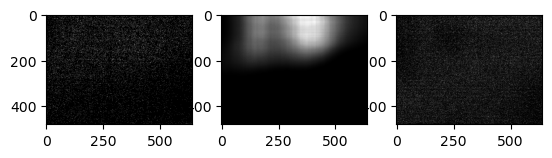

In [58]:
direct_path = os.path.join("bora_data", "right_data", "044")
clean_img = np.load(os.path.join(direct_path, "clean.npy"))
noisy_img = np.load(os.path.join(direct_path, "noisy0000.npy"))
fwc = np.load(os.path.join("bora_data", "right_data", "fwc.npy"))
# Plot the clean and noisy images
fig, ax = plt.subplots(1, 3)
ax[0].imshow(noisy_img, cmap="gray")
ax[1].imshow(clean_img, cmap="gray")
ax[2].imshow(fwc, cmap="gray")
plt.show()

In [115]:
params_path = "./bora_data/test_T7_params.mat"
params = sio.loadmat(params_path)

In [116]:
params.keys()

dict_keys(['__header__', '__version__', '__globals__', 'left_fwc', 'left_g', 'left_h', 'left_shot', 'left_read', 'left_row', 'left_rowt', 'left_quant', 'left_dark', 'right_fwc', 'right_g', 'right_h', 'right_shot', 'right_read', 'right_row', 'right_rowt', 'right_quant', 'right_dark'])

In [117]:
params["left_shot"], params['left_row'], params['left_rowt'], params['left_quant']

(array([[0.42905113]], dtype=float32),
 array([[4.6791887]], dtype=float32),
 array([[4.6738763]], dtype=float32),
 array([[5.169001]], dtype=float32))

In [118]:
# Plot image
def plot_image(img):
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)

In [119]:
# Generate a gray image
gray = np.ones((480, 640)) * 128
gray = gray.astype(np.uint8)

In [129]:
simulated = simulate(None, gray, params, 78.01)

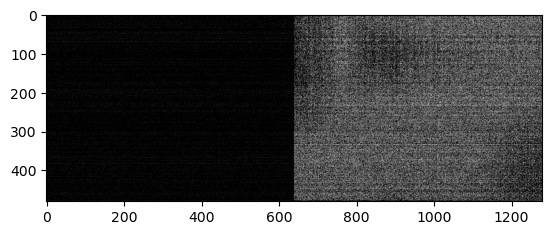

In [130]:
plt.imshow(np.clip(simulated[0, 0] / 16, 0, 255).astype(np.uint8), cmap="gray")